In [269]:
import os 
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch import nn
import nltk
import re
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
# from keras.preprocessing.text import Tokenizer

In [270]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to E:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [271]:
arabic_stopwords = nltk.corpus.stopwords.words("arabic")
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
def preprocess(text):
    tweet = re.sub(r'[^\w\s]', ' ', text)
    tweet = re.sub(r'\w*_\w*', '', tweet)
    tweet = re.sub(r'http\S+', '',tweet)
    tweet = re.sub(r'ة\s','ه ' ,tweet)
    tweet = re.sub(r"أ", "ا", tweet)
    tweet = re.sub(r"آ", "ا", tweet)
    tweet = re.sub(r"إ", "ا", tweet)
    tweet = re.sub(r"ى", "ي", tweet)
    tweet = re.sub(r"اللة", "الله", tweet)
    tweet = re.sub(arabic_diacritics,"", tweet)
    tweet = re.sub(r'^\w\s', ' ', tweet)
    tweet = re.sub(r'[A-Za-z]', ' ', tweet)
    tweet = re.sub(r'[<LF>#]', ' ',tweet)
    tweet = re.sub(r'\d', '',tweet)
    tweet = ' '.join([word for word in tweet.split() if word not in arabic_stopwords])
    return tweet

In [272]:
train_data = pd.read_csv("train.csv")
dev_data = pd.read_csv("dev.csv")

In [273]:
train_c = np.array(train_data['category'].tolist())
train_s = np.array(train_data['stance'].tolist())
train_t = np.array(train_data['text'].tolist())

tmp_neg = train_data[train_data['stance']==-1].sample(400,random_state=42,replace=True)
tmp_neu = train_data[train_data['stance']==0].sample(500,random_state=42,replace=True)
tmp_pos = train_data[train_data['stance']==1].sample(950,random_state=42,replace=True)

train_data = pd.concat([tmp_neg,tmp_neu,tmp_pos])
#train_data = train_data.sample(frac=1)

In [274]:
train_category= np.array(train_data['category'].tolist())
train_stance=np.array(train_data['stance'].tolist())
train_text = np.array(train_data['text'].tolist())

for i in range(len(train_text)):
    train_text[i] = preprocess(train_text[i])

dev_category= np.array(dev_data['category'].tolist())
dev_stance=np.array(dev_data['stance'].tolist())
dev_text = np.array(dev_data['text'].tolist())

for i in range(len(dev_text)):
    dev_text[i] = preprocess(dev_text[i])

In [275]:
# the Bag of Words features
tokenized_data=[]
for i in train_text:
    tokenized_data.append( nltk.tokenize.wordpunct_tokenize(i))

word2count = {} # it is the vocab 
for sent in tokenized_data:
	for word in sent:
		if word not in word2count.keys():
			word2count[word] = 1
		else:
			word2count[word] += 1
vocabsize=len(word2count.keys())

In [276]:
vocab_size = len(word2count.keys())
id2word = {i: word for i, word in enumerate(list(word2count.keys()))}
id2word[vocab_size]="pad"
id2word[vocab_size+1]="unk"
vocab_size+=2
word2id = {word: i for i, word in id2word.items()}

In [277]:
print(len(max(train_text, key=len).split()))
print(max(train_text, key=len).split())

46
['الفيروس', 'تحور', 'واصبح', 'اكثر', 'ذكاء', 'طبيعي', 'فمهمته', 'ان', 'يعيش', 'ودائما', 'سينجح', 'الانسان', 'البشري', 'يتحور', 'ومازال', 'يعتقد', 'بان', 'التطعيم', 'سيفيد', 'وكل', 'سنه', 'تطعيم', 'جديد', 'وكل', 'مافيروس', 'جديد', 'يظهر', 'يخترعوا', 'تطعيم', 'وهكذا', 'طب', 'مالاسهل', 'نقوي', 'المناعه', 'وهي', 'تقوم', 'باللازم', 'ةنظام', 'تغذيه', 'وفيتامينات', 'وحياه', 'صحيه', 'عالم', 'مجانين', 'اقسم', 'بالله']


In [278]:
train_paded=list(train_text)
length = len(str(max(train_paded, key=len)).split())

print(len(max(train_paded, key=len).split()))
for i in range(len(train_paded)):
    train_paded[i]=train_paded[i].split()+["pad" for v in range(length-len(train_paded[i].split()))]
train_paded = np.array(train_paded)

print(len(max(train_paded, key=len)))

test_paded= list(dev_text)
for i in range(len(test_paded)):
    test_paded[i]=str(test_paded[i]).split()+["pad" for v in range(length-len(str(test_paded[i]).split()))]
test_paded = np.array(test_paded)



46
46


In [279]:
print(vocab_size)

10273


In [280]:
train_ided=[[]for i in range(len(train_paded))]
for i in range(len(train_paded)):
    for word in train_paded[i]:
        train_ided[i].append(word2id[word])

test_ided=[[]for i in range(len(test_paded))]
for i in range(len(test_paded)):
    for word in test_paded[i]:
        if(word in word2id.keys()):
            test_ided[i].append(word2id[word])
        else:
            test_ided[i].append(word2id["unk"])



In [281]:
class textDataset_stan(torch.utils.data.Dataset):

  def __init__(self, data,stnc,vocsize):
    """
    This is the constructor of the NERDataset
    Inputs:
    - x: a list of lists where each list contains the ids of the tokens
    - y: a list of lists where each list contains the label of each token in the sentence
    - pad: the id of the <PAD> token (to be used for padding all sentences and labels to have the same length)
    """
    ##################### TODO: create two tensors one for x and the other for labels ###############################
    #pass
    self.tens_data = torch.tensor(data)
    self.tens_stance = torch.tensor(stnc)
    self.vocab_size = vocsize

    #################################################################################################################

  def __len__(self):
    """
    This function should return the length of the dataset (the number of sentences)
    """
    ###################### TODO: return the length of the dataset #############################
    #pass
    return self.tens_data.shape[0]
    ###########################################################################################

  def __getitem__(self, idx):
    """
    This function returns a subset of the whole dataset
    """
    ###################### TODO: return a tuple of x and y ###################################
    #pass
    return self.tens_data[idx],self.tens_stance[idx]
    ##########################################################################################

In [282]:
class stansize(nn.Module):
  def __init__(self, vocab_size, embedding_dim=7000, hidden_size=80, n_classes=3):
    """
    The constructor of our NER model
    Inputs:
    - vacab_size: the number of unique words
    - embedding_dim: the embedding dimension
    - n_classes: the number of final classes (tags)
    """
    super(stansize, self).__init__()
    ####################### TODO: Create the layers of your model #######################################
    # (1) Create the embedding layer
    self.embedding = nn.Embedding(vocab_size,embedding_dim)

    # (2) Create an LSTM layer with hidden size = hidden_size and batch_first = True
    self.lstm = nn.LSTM(embedding_dim,hidden_size,1,batch_first=True)

    # (3) Create a linear layer with number of neorons = n_classes
    self.linear = nn.Linear(hidden_size,n_classes)


    #####################################################################################################

  def forward(self, sentences):
    """
    This function does the forward pass of our model
    Inputs:
    - sentences: tensor of shape (batch_size, max_length)

    Returns:
    - final_output: tensor of shape (batch_size, max_length, n_classes)
    """
    ######################### TODO: implement the forward pass ####################################
    emb_out= self.embedding(sentences)
    lstm_out,_= self.lstm(emb_out)
    final_output = self.linear(lstm_out)

    ###############################################################################################
    return final_output

    # tweet(92) -> anhy stance

In [283]:
model = stansize(vocab_size=vocab_size)
print(model)

stansize(
  (embedding): Embedding(10273, 7000)
  (lstm): LSTM(7000, 80, batch_first=True)
  (linear): Linear(in_features=80, out_features=3, bias=True)
)


In [284]:
def train_stan(model, train_dataset, batch_size=512, epochs=5, learning_rate=0.1):
  """
  This function implements the training logic
  Inputs:
  - model: the model ot be trained
  - train_dataset: the training set of type NERDataset
  - batch_size: integer represents the number of examples per step
  - epochs: integer represents the total number of epochs (full training pass)
  - learning_rate: the learning rate to be used by the optimizer
  """

  ############################## TODO: replace the Nones in the following code ##################################
  
  # (1) create the dataloader of the training set (make the shuffle=True)
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # (2) make the criterion cross entropy loss
  criterion = nn.CrossEntropyLoss()

  # (3) create the optimizer (Adam)
  optimizer = torch.optim.Adam(model.parameters(),learning_rate)

  # GPU configuration
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  if use_cuda:
    model = model.cuda()
    criterion = criterion.cuda()

  for epoch_num in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    for train_input, train_label in tqdm(train_dataloader):

      # (4) move the train input to the device
      # we are moving train label
      train_label = train_label.to(device)

      # (5) move the train label to the device
      # we are moving train input
      train_input = train_input.to(device)

      # (6) do the forward pass
      output = model.forward(train_input)
      
      # (7) loss calculation (you need to think in this part how to calculate the loss correctly)
      size=output.shape
      out2 = output[: ,-1 ,:]
      #print(out2.shape)
      #print(train_label.shape)
      batch_loss = criterion(out2,train_label)

      # (8) append the batch loss to the total_loss_train
      total_loss_train += batch_loss
      #print(train_label.shape)
      # (9) calculate the batch accuracy (just add the number of correct predictions)
      acc = float((torch.argmax(out2,dim=1) == train_label).sum())
      #print(torch.argmax(out2,dim=1))
      #print(train_label)
      #print(float((torch.argmax(out2,dim=1) == train_label).sum()))
      total_acc_train += acc

      # (10) zero your gradients
      optimizer.zero_grad()

      # (11) do the backward pass
      batch_loss.backward()

      nn.utils.clip_grad_norm(model.parameters(),max_norm=1)

      # (12) update the weights with your optimizer
      optimizer.step()

      
    # epoch loss
    epoch_loss = total_loss_train / len(train_dataset)

    # (13) calculate the accuracy
    size = train_dataset.tens_data.shape
    epoch_acc = total_acc_train / (size[0])

    print(
        f'Epochs: {epoch_num + 1} | Train Loss: {epoch_loss} \
        | Train Accuracy: {epoch_acc}\n')

  ##############################################################################################################

In [285]:
train_dataset_stan = textDataset_stan(train_ided,(train_stance+1).astype(np.longlong),vocsize=vocab_size)

train_stan(model, train_dataset_stan)

  0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-284-a4b283cc28d1>:70: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(),max_norm=1)
  0%|          | 0/4 [00:00<?, ?it/s]

Epochs: 1 | Train Loss: 0.0035813760478049517         | Train Accuracy: 0.3762162162162162



  0%|          | 0/4 [00:00<?, ?it/s]

Epochs: 2 | Train Loss: 0.0032055045012384653         | Train Accuracy: 0.4097297297297297



  0%|          | 0/4 [00:00<?, ?it/s]

Epochs: 3 | Train Loss: 0.0026587413158267736         | Train Accuracy: 0.4918918918918919



  0%|          | 0/4 [00:00<?, ?it/s]

Epochs: 4 | Train Loss: 0.0022890984546393156         | Train Accuracy: 0.5572972972972973



100%|██████████| 4/4 [00:20<00:00,  5.06s/it]

Epochs: 5 | Train Loss: 0.0020261467434465885         | Train Accuracy: 0.6145945945945946



In [286]:
def evaluate_stan(model, test_dataset, batch_size=512):
  """
  This function takes a NER model and evaluates its performance (accuracy) on a test data
  Inputs:
  - model: a NER model
  - test_dataset: dataset of type NERDataset
  """
  ########################### TODO: Replace the Nones in the following code ##########################

  # (1) create the test data loader
  test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)

  # GPU Configuration
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  if use_cuda:
    model = model.cuda()

  total_acc_test = 0
  
  # (2) disable gradients
  with torch.no_grad():

    for test_input, test_label in tqdm(test_dataloader):
      # (3) move the test input to the device
      # we are moving test label
      test_label = test_label.to(device)

      # (4) move the test label to the device
      # we are moving test input
      test_input = test_input.to(device)

      # (5) do the forward pass
      output = model.forward(test_input)
      out2 = output[: ,-1 ,:]

      #print(torch.argmax(out2,dim=1)-1)
      #print(test_label-1)
      confusion_matrix = metrics.confusion_matrix(test_label,torch.argmax(out2,dim=1))
      cm_df = pd.DataFrame(confusion_matrix)
                     #,index = ['0','1','2','3','4','5','6','7','8','9'], 
                     #columns = ['0','1','2','3','4','5','6','7','8','9'])
      plt.figure(figsize=(5,4))
      sns.heatmap(cm_df, annot=True)
      plt.title('Confusion Matrix')
      plt.ylabel('Actal Values')
      plt.xlabel('Predicted Values')
      plt.show()
      print(metrics.f1_score(test_label,torch.argmax(out2,dim=1),  average="macro"))


      # accuracy calculation (just add the correct predicted items to total_acc_test)
      acc = float((torch.argmax(out2,dim=1) == test_label).sum())
      
      #print(torch.argmax(out2,dim=1))
      #print(test_label)
      total_acc_test += acc
    
    # (6) calculate the over all accuracy
    size = test_dataset.tens_data.shape
    total_acc_test /= size[0]
  ##################################################################################################

  
  print(f'\nTest Accuracy: {total_acc_test}')

  0%|          | 0/2 [00:00<?, ?it/s]

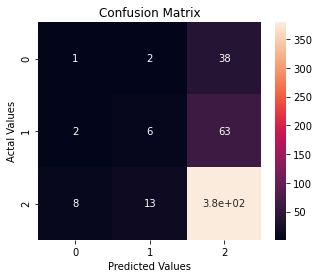

 50%|█████     | 1/2 [00:00<00:00,  1.10it/s]

0.34341998581129013


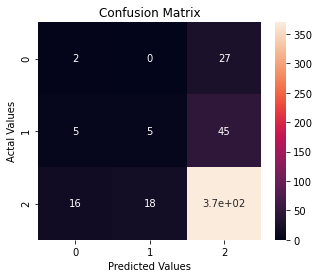

100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

0.3599442322846578

Test Accuracy: 0.763


In [287]:
test_dataset_stan = textDataset_stan(test_ided,(dev_stance+1).astype(np.longlong),vocsize=vocab_size)
evaluate_stan(model, test_dataset_stan)

In [386]:
train_data = pd.read_csv("train.csv")
dev_data = pd.read_csv("dev.csv")

In [387]:
tmp_c0 = train_data[train_data['category']=="restrictions"]
tmp_c1 = train_data[train_data['category']=="plan"]
tmp_c2 = train_data[train_data['category']=="advice"]
tmp_c3 = train_data[train_data['category']=="info_news"]
tmp_c4 = train_data[train_data['category']=="celebrity"]
tmp_c5 = train_data[train_data['category']=="requests"]
tmp_c6 = train_data[train_data['category']=="personal"]
tmp_c7 = train_data[train_data['category']=="others"]
tmp_c8 = train_data[train_data['category']=="rumors"]
tmp_c9 = train_data[train_data['category']=="unrelated"]

print(len(tmp_c0))
print(len(tmp_c1))
print(len(tmp_c2))
print(len(tmp_c3))
print(len(tmp_c4))
print(len(tmp_c5))
print(len(tmp_c6))
print(len(tmp_c7))
print(len(tmp_c8))
print(len(tmp_c9))

18
606
67
3616
975
112
1025
167
79
323


In [388]:
tmp_c0 = train_data[train_data['category']=="restrictions"].sample(18)
tmp_c1 = train_data[train_data['category']=="plan"].sample(606)
tmp_c2 = train_data[train_data['category']=="advice"].sample(67)
tmp_c3 = train_data[train_data['category']=="info_news"].sample(1400)
tmp_c4 = train_data[train_data['category']=="celebrity"].sample(975)
tmp_c5 = train_data[train_data['category']=="requests"].sample(112)
tmp_c6 = train_data[train_data['category']=="personal"].sample(1025)
tmp_c7 = train_data[train_data['category']=="others"].sample(167)
tmp_c8 = train_data[train_data['category']=="rumors"].sample(79)
tmp_c9 = train_data[train_data['category']=="unrelated"].sample(323)

train_data = pd.concat([tmp_c0,tmp_c1,tmp_c2,tmp_c3,tmp_c4,tmp_c5,tmp_c6,tmp_c7,tmp_c8,tmp_c9]).sort_index()

In [389]:
print(len(train_data))

4772


In [390]:
train_category= np.array(train_data['category'].tolist())
train_stance=np.array(train_data['stance'].tolist())
train_text = np.array(train_data['text'].tolist())

for i in range(len(train_text)):
    train_text[i] = preprocess(train_text[i])

dev_category= np.array(dev_data['category'].tolist())
dev_stance=np.array(dev_data['stance'].tolist())
dev_text = np.array(dev_data['text'].tolist())

for i in range(len(dev_text)):
    dev_text[i] = preprocess(dev_text[i])
    
# the Bag of Words features
tokenized_data=[]
for i in train_text:
    tokenized_data.append( nltk.tokenize.wordpunct_tokenize(i))

word2count = {} # it is the vocab 
for sent in tokenized_data:
	for word in sent:
		if word not in word2count.keys():
			word2count[word] = 1
		else:
			word2count[word] += 1

vocab_size = len(word2count.keys())
print(vocab_size)
id2word = {i: word for i, word in enumerate(list(word2count.keys()))}
id2word[vocab_size]="pad"
id2word[vocab_size+1]="unk"
vocab_size+=2
word2id = {word: i for i, word in id2word.items()}
train_paded=list(train_text)
length = len(str(max(train_paded, key=len)).split())

print(len(max(train_paded, key=len).split()))
for i in range(len(train_paded)):
    train_paded[i]=train_paded[i].split()+["pad" for v in range(length-len(train_paded[i].split()))]
train_paded = np.array(train_paded)

print(len(max(train_paded, key=len)))

test_paded= list(dev_text)
for i in range(len(test_paded)):
    test_paded[i]=str(test_paded[i]).split()+["pad" for v in range(length-len(str(test_paded[i]).split()))]
test_paded = np.array(test_paded)


train_ided=[[]for i in range(len(train_paded))]
for i in range(len(train_paded)):
    for word in train_paded[i]:
        train_ided[i].append(word2id[word])

test_ided=[[]for i in range(len(test_paded))]
for i in range(len(test_paded)):
    for word in test_paded[i]:
        if(word in word2id.keys()):
            test_ided[i].append(word2id[word])
        else:
            test_ided[i].append(word2id["unk"])



20688
92
92


In [391]:
class textDataset_cat(torch.utils.data.Dataset):

  def __init__(self, data,cat,vocsize):
    """
    This is the constructor of the NERDataset
    Inputs:
    - x: a list of lists where each list contains the ids of the tokens
    - y: a list of lists where each list contains the label of each token in the sentence
    - pad: the id of the <PAD> token (to be used for padding all sentences and labels to have the same length)
    """
    ##################### TODO: create two tensors one for x and the other for labels ###############################
    #pass
    self.tens_data = torch.tensor(data)
    self.tens_cat = torch.tensor(cat)
    self.vocab_size = vocsize

    #################################################################################################################

  def __len__(self):
    """
    This function should return the length of the dataset (the number of sentences)
    """
    ###################### TODO: return the length of the dataset #############################
    #pass
    return self.tens_data.shape[0]
    ###########################################################################################

  def __getitem__(self, idx):
    """
    This function returns a subset of the whole dataset
    """
    ###################### TODO: return a tuple of x and y ###################################
    #pass
    return self.tens_data[idx],self.tens_cat[idx]
    ##########################################################################################

In [392]:
class categorize(nn.Module):
  def __init__(self, vocab_size, embedding_dim=7000, hidden_size=80, n_classes=10):
    """
    The constructor of our NER model
    Inputs:
    - vacab_size: the number of unique words
    - embedding_dim: the embedding dimension
    - n_classes: the number of final classes (tags)
    """
    super(categorize, self).__init__()
    ####################### TODO: Create the layers of your model #######################################
    # (1) Create the embedding layer
    self.embedding = nn.Embedding(vocab_size,embedding_dim)

    # (2) Create an LSTM layer with hidden size = hidden_size and batch_first = True
    self.lstm = nn.LSTM(embedding_dim,hidden_size,1,batch_first=True)

    # (3) Create a linear layer with number of neorons = n_classes
    self.linear = nn.Linear(hidden_size,n_classes)


    #####################################################################################################

  def forward(self, sentences):
    """
    This function does the forward pass of our model
    Inputs:
    - sentences: tensor of shape (batch_size, max_length)

    Returns:
    - final_output: tensor of shape (batch_size, max_length, n_classes)
    """
    ######################### TODO: implement the forward pass ####################################
    emb_out= self.embedding(sentences)
    lstm_out,_= self.lstm(emb_out)
    final_output = self.linear(lstm_out)

    ###############################################################################################
    return final_output

    # tweet(92) -> anhy stance

In [393]:
model = categorize(vocab_size=vocab_size)
print(model)

categorize(
  (embedding): Embedding(20690, 7000)
  (lstm): LSTM(7000, 80, batch_first=True)
  (linear): Linear(in_features=80, out_features=10, bias=True)
)


In [394]:
def train_cat(model, train_dataset, batch_size=512, epochs=5, learning_rate=0.1):
  """
  This function implements the training logic
  Inputs:
  - model: the model ot be trained
  - train_dataset: the training set of type NERDataset
  - batch_size: integer represents the number of examples per step
  - epochs: integer represents the total number of epochs (full training pass)
  - learning_rate: the learning rate to be used by the optimizer
  """

  ############################## TODO: replace the Nones in the following code ##################################
  
  # (1) create the dataloader of the training set (make the shuffle=True)
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # (2) make the criterion cross entropy loss
  criterion = nn.CrossEntropyLoss()

  # (3) create the optimizer (Adam)
  optimizer = torch.optim.Adam(model.parameters(),learning_rate)

  # GPU configuration
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  if use_cuda:
    model = model.cuda()
    criterion = criterion.cuda()

  for epoch_num in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    for train_input, train_label in tqdm(train_dataloader):

      # (4) move the train input to the device
      # we are moving train label
      train_label = train_label.to(device)

      # (5) move the train label to the device
      # we are moving train input
      train_input = train_input.to(device)

      # (6) do the forward pass
      output = model.forward(train_input)
      
      # (7) loss calculation (you need to think in this part how to calculate the loss correctly)
      size=output.shape
      out2 = output[: ,-1 ,:]
      #print(out2.shape)
      #print(train_label.shape)
      batch_loss = criterion(out2,train_label)

      # (8) append the batch loss to the total_loss_train
      total_loss_train += batch_loss
      #print(train_label.shape)
      # (9) calculate the batch accuracy (just add the number of correct predictions)
      acc = float((torch.argmax(out2,dim=1) == train_label).sum())
      #print(torch.argmax(out2,dim=1))
      #print(train_label)
      #print(float((torch.argmax(out2,dim=1) == train_label).sum()))
      total_acc_train += acc

      # (10) zero your gradients
      optimizer.zero_grad()

      # (11) do the backward pass
      batch_loss.backward()

      nn.utils.clip_grad_norm(model.parameters(),max_norm=1)

      # (12) update the weights with your optimizer
      optimizer.step()

      
    # epoch loss
    epoch_loss = total_loss_train / len(train_dataset)

    # (13) calculate the accuracy
    size = train_dataset.tens_data.shape
    epoch_acc = total_acc_train / (size[0])

    print(
        f'Epochs: {epoch_num + 1} | Train Loss: {epoch_loss} \
        | Train Accuracy: {epoch_acc}\n')

  ##############################################################################################################

In [395]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_category)
train_category = le.transform(train_category)

le = preprocessing.LabelEncoder()
le.fit(dev_category)
dev_category = le.transform(dev_category)


In [396]:
train_dataset = textDataset_cat(train_ided,train_category.astype(np.longlong),vocsize=vocab_size)
test_dataset = textDataset_cat(test_ided,dev_category.astype(np.longlong),vocsize=vocab_size)
train_cat(model, train_dataset)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-394-3f545015b7cb>:70: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(),max_norm=1)
  0%|          | 0/10 [00:00<?, ?it/s]

Epochs: 1 | Train Loss: 0.004503895528614521         | Train Accuracy: 0.20033528918692373



  0%|          | 0/10 [00:00<?, ?it/s]

Epochs: 2 | Train Loss: 0.003961547743529081         | Train Accuracy: 0.26508801341156746



  0%|          | 0/10 [00:00<?, ?it/s]

Epochs: 3 | Train Loss: 0.003897956805303693         | Train Accuracy: 0.30259849119865884



  0%|          | 0/10 [00:00<?, ?it/s]

Epochs: 4 | Train Loss: 0.0038000966887921095         | Train Accuracy: 0.32523051131601005



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]

Epochs: 5 | Train Loss: 0.0036939536221325397         | Train Accuracy: 0.3440905280804694



In [397]:
def evaluate_cat(model, test_dataset, batch_size=512):
  """
  This function takes a NER model and evaluates its performance (accuracy) on a test data
  Inputs:
  - model: a NER model
  - test_dataset: dataset of type NERDataset
  """
  ########################### TODO: Replace the Nones in the following code ##########################

  # (1) create the test data loader
  test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)

  # GPU Configuration
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  if use_cuda:
    model = model.cuda()

  total_acc_test = 0
  o = []
  # (2) disable gradients
  with torch.no_grad():

    for test_input, test_label in tqdm(test_dataloader):
      # (3) move the test input to the device
      # we are moving test label
      test_label = test_label.to(device)

      # (4) move the test label to the device
      # we are moving test input
      test_input = test_input.to(device)

      # (5) do the forward pass
      output = model.forward(test_input)
      out2 = output[: ,-1 ,:]
      confusion_matrix = metrics.confusion_matrix(torch.argmax(out2,dim=1), test_label)
      cm_df = pd.DataFrame(confusion_matrix)
                     #,index = ['0','1','2','3','4','5','6','7','8','9'], 
                     #columns = ['0','1','2','3','4','5','6','7','8','9'])
      plt.figure(figsize=(12,11))
      sns.heatmap(cm_df, annot=True)
      plt.title('Confusion Matrix')
      plt.ylabel('Actal Values')
      plt.xlabel('Predicted Values')
      plt.show()
      print(metrics.f1_score(torch.argmax(out2,dim=1), test_label, average="macro"))



      # accuracy calculation (just add the correct predicted items to total_acc_test)
      acc = float((torch.argmax(out2,dim=1) == test_label).sum())
      #print(torch.argmax(out2,dim=1))
      #print(test_label)
      total_acc_test += acc
    
    # (6) calculate the over all accuracy
    size = test_dataset.tens_data.shape
    total_acc_test /= size[0]
    o = torch.argmax(out2,dim=1)
  ##################################################################################################

  
  print(f'\nTest Accuracy: {total_acc_test}')
  return o

  0%|          | 0/1 [00:00<?, ?it/s]

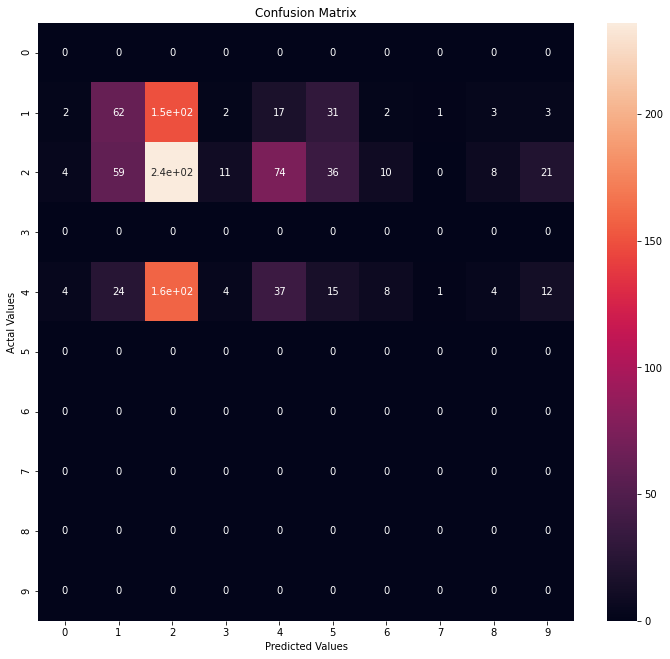

100%|██████████| 1/1 [00:03<00:00,  3.74s/it]

0.09536389264843867

Test Accuracy: 0.335


In [398]:
o = evaluate_cat(model, test_dataset,batch_size=len(test_dataset))

In [385]:
print (o)

tensor([4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 4, 4, 2, 4, 4, 2, 4, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 4, 2, 4, 2, 2,
        2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4,
        2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 4,
        2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 4, 2, 4, 4, 2, 2, 2, 2, 2,
        2, 4, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 4, 2, 4, 2, 2, 2,
        2, 4, 2, 2, 4, 4, 2, 2, 2, 4, 4, 2, 2, 2, 4, 2, 2, 4, 2, 4, 4, 2, 2, 2,
        2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 2, 4, 2, 4, 2, 2, 2, 2, 2,
        2, 2, 2, 4, 2, 2, 2, 4, 4, 4, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2,
        2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 4, 2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 4, 2, 2, 2,
        2, 4, 4, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 4, 4, 2, 4, 2, 2, 4, 2, 4, 2,
        2, 2, 2, 4, 2, 4, 4, 2, 2, 2, 2,